In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns

import candas as can
import gumbi as gmb
from candas.lims import Librarian, library
from candas.learn import ParameterSet

base_pth, code_pth, data_pth, _, fig_pth = can.utils.setup_paths(make_missing=False)
plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
ps = ParameterSet.load(data_pth / 'ADVI_ParameterSets_220528.pkl')
data = (ps.wide
        .query('Metric == "mean"')
        .astype({'BP': float})
        .groupby(['Target', 'Reporter'])
        .mean()
        .reset_index()
        )

ds = gmb.DataSet(
    data = data,
    outputs = ['F0_lg', 'r', 'K', 'm'],
    log_vars = ['BP', 'K', 'm', 'r'],
    logit_vars = ['GC'],
    )

In [3]:
gp = gmb.GP(ds).fit(
    # outputs='r',
    continuous_dims=['BP', 'GC'],
    linear_dims=['BP', 'GC'],
    categorical_dims=['Reporter']
    )

In [4]:
limits = gp.parray(GC=[0.2, 0.8], BP=[10, 600])
reporter = 'HEX'
XY = gp.prepare_grid(limits=limits)
r = gp.predict_grid(
    output='r',
    with_noise=False,
    categorical_levels={'Reporter': reporter}
)
BP, GC = XY['BP'], XY['GC']

: 

: 

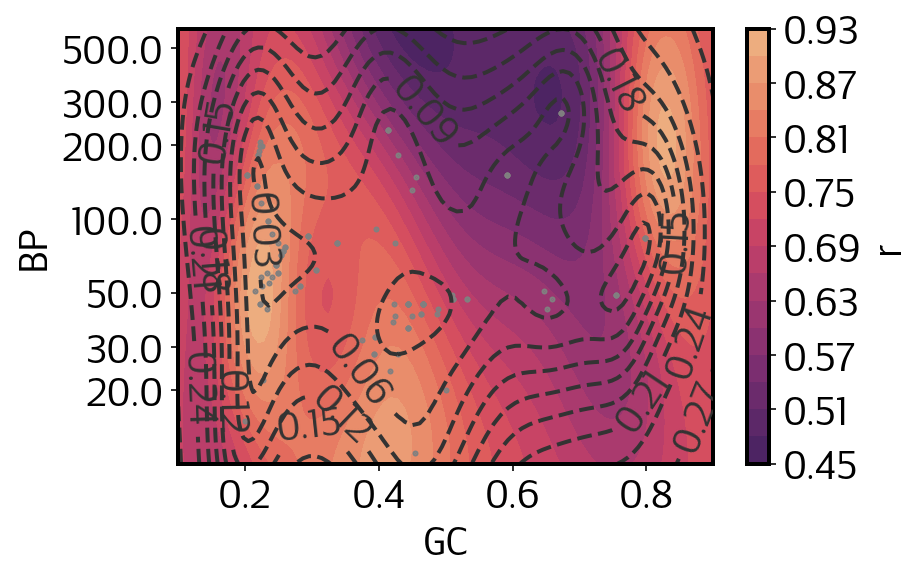

In [ ]:
pp = gmb.ParrayPlotter(x=GC, y=BP, z=r, 
                    #    x_scale='standardized',
                       y_scale='standardized'
                       )

cmap=sns.color_palette('flare_r', as_cmap=True)
rnorm = mpl.colors.Normalize()
rnorm(r.μ)

cs = pp(plt.contourf, levels=16, cmap='flare_r', norm=rnorm)
pp.colorbar(cs)

ax=plt.gca()

yticks = gp.parray(BP=[20, 30, 50, 100, 200, 300, 500])
ax.set_yticks(yticks['BP'].z.values())
ax.set_yticklabels(yticks.values())

gc = ds.wide.query('Reporter == @reporter').GC
bp = ds.wide.z.query('Reporter == @reporter').BP

ax.scatter(gc, bp, c='0.5', cmap='flare_r', norm=rnorm,
           s=1
           )

cs = ax.contour(GC.values(), BP.z.values(), r.σ, levels=8, colors='0.2', linestyles='--')
ax.clabel(cs);


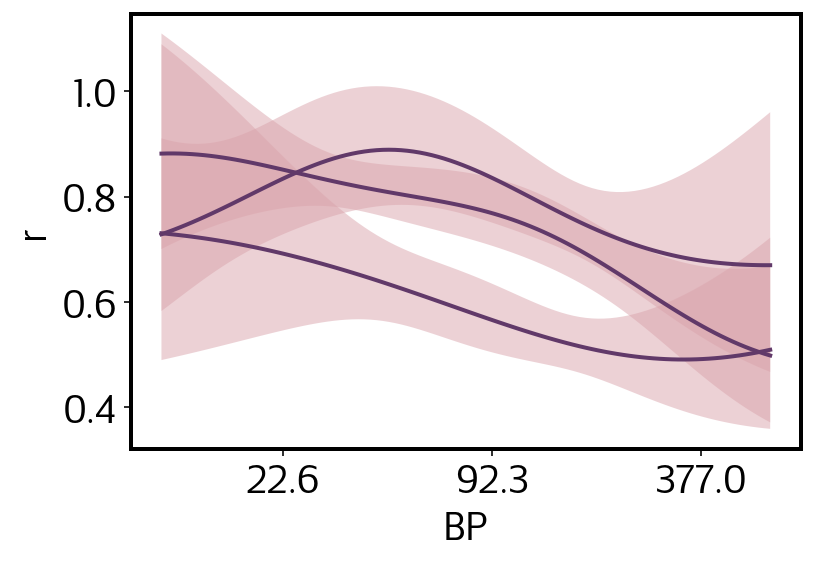

In [ ]:
for gc in [0.25, 0.5, 0.75]:
    x_pa, y_upa = gp.get_conditional_prediction(GC=gc)
    gmb.ParrayPlotter(x_pa.z, y_upa).plot()

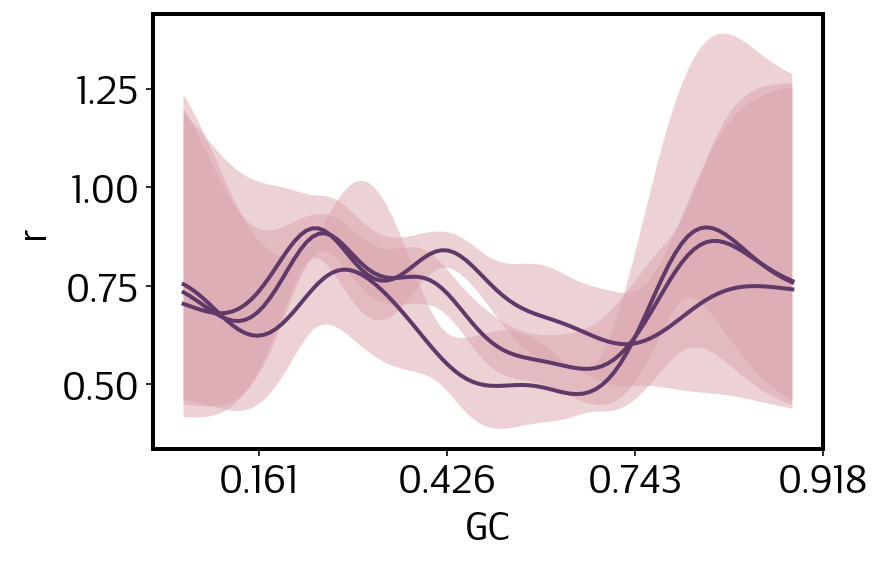

In [ ]:
for bp in [30, 100, 300]:
    x_pa, y_upa = gp.get_conditional_prediction(BP=bp)
    gmb.ParrayPlotter(x_pa.z, y_upa).plot()

In [ ]:
data.describe()

,Well,Copies,lg10_Copies,BP,GC,F0_lg,K,m,r,ρ,τ
count,222.000000,2.220000e+02,222.000000,222.00000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,150.279064,2.009442e+07,5.096292,138.68018,0.442650,-5.286508,0.640938,0.014634,0.716519,0.230195,25.012006
std,97.911231,5.510421e+06,0.459873,111.84573,0.140120,1.157324,0.164193,0.008796,0.148097,0.064800,4.929339
min,37.500000,1.851850e+06,4.500000,30.00000,0.131250,-9.711139,0.249376,0.004820,0.412041,0.114077,16.491975
25%,61.250000,1.587301e+07,5.000000,76.25000,0.341772,-5.936813,0.520302,0.008521,0.602589,0.177966,21.613946
50%,105.500000,1.851850e+07,5.000000,89.00000,0.431818,-5.262337,0.630446,0.011740,0.724611,0.221107,23.646768
75%,259.375000,2.525252e+07,5.000000,160.00000,0.524765,-4.411670,0.732344,0.018381,0.826852,0.276722,27.446867
max,347.500000,5.050000e+07,7.000000,575.00000,0.852273,-3.078805,1.282057,0.063265,1.030674,0.383248,47.099452


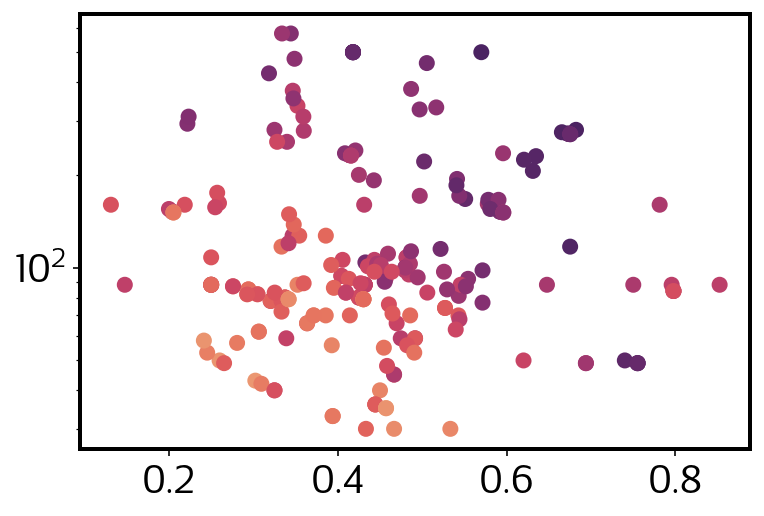

In [ ]:
plt.scatter(data.GC, data.BP, c=data.r, cmap='flare_r')
plt.yscale('log')